In [1]:
import sys

sys.path.insert(0, "../")

import torch
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from src_code.task_utils.config_parser import ConfigParser
from src_code.data_utils.dataset_utils import CaptchaDataset
from src_code.data_utils.preprocessing import get_img_transform, get_rectangle_img_transform
from src_code.model_utils.mnist_ssd import SSD, BaseConv, pretty_print_module_list, AuxConv
import src_code.model_utils.utils_mnist_ssd as utils_mnist_ssd
from src_code.model_utils.mnist_ssd import SSD
from torch import nn
import yaml
from torchvision.utils import draw_bounding_boxes


### Load Config Files

In [2]:

# Load the base config
base_config_path = "../configs/configs_common_notebook.yaml"
if not Path(base_config_path).exists():
    raise FileNotFoundError(f"Base config file not found: {base_config_path}")

with open(base_config_path, "r") as file:
    base_config_dict = yaml.safe_load(file)

configs = ConfigParser(base_config_dict).get_parser()

# Load the SSD-specific config
ssd_config_path = "../configs/default_ssd_configs.yaml"
if not Path(ssd_config_path).exists():
    raise FileNotFoundError(f"SSD config file not found: {ssd_config_path}")

with open(ssd_config_path, "r") as file:
    ssd_config_dict = yaml.safe_load(file)

configs.update(ssd_config_dict)


config = {'task': 'train', 'data_configs': {'train_path': 'datasets/utn_dataset_curated/part2/train', 'val_path': 'datasets/utn_dataset_curated/part2/val', 'test_path': 'datasets/utn_dataset_curated/part2/test', 'preprocessing_related': {'color': False, 'mean': 0.5, 'std': 0.5, 'downscale_factor': 4}, 'dataset_related': {'train_preprocessed_dir': '../datasets/utn_dataset_curated/part2/train/images', 'val_preprocessed_dir': '../datasets/utn_dataset_curated/part2/val/images', 'test_preprocessed_dir': '../datasets/utn_dataset_curated/part2/test/images', 'train_labels_dir': '../datasets/utn_dataset_curated/part2/train/labels', 'val_labels_dir': '../datasets/utn_dataset_curated/part2/val/labels', 'augment': True, 'shuffle': False}, 'augmentation_related': {'flip_prob': 0.5, 'scale_range': '(0.8, 1.2)', 'zoom_prob': 0.3, 'saturation_prob': 0, 'rotation_prob': 0}}, 'model_configs': {'name': 'ssd_mnist', 'save_checkpoint': True, 'log_gradients': False, 'checkpoint': None, 'print_freq': 500, 'e

### Load Test Dataset

In [3]:

test_dataset = CaptchaDataset(
    configs.test_preprocessed_dir,
    labels_dir=None,
    augment=False,
    config=configs,
    img_transform=get_rectangle_img_transform(configs)
)

print(test_dataset)

Dataset CaptchaDataset
    Number of datapoints: 5
    Root location: ../datasets/utn_dataset_curated/part2/test/images


### Load Model

In [4]:
base_conv = BaseConv(configs.base_conv_conv_layers, 
                    configs.base_conv_input_size, chosen_fm=[-2, -1],
                    norm=nn.BatchNorm2d, act_fn=nn.ReLU(), spectral=False)

In [5]:
new_h = configs.img_height // configs.downscale_factor
new_w = configs.img_width // configs.downscale_factor
setattr(configs, "base_conv_input_size", [new_h, new_w])

base_size = pretty_print_module_list(base_conv.module_list, torch.zeros([1,1,configs.base_conv_input_size[0], configs.base_conv_input_size[1]]))

aux_conv = AuxConv(configs.aux_conv_conv_layers, 
                configs.aux_conv_input_size, norm=nn.BatchNorm2d, act_fn=nn.ReLU(), spectral=False)
aux_size = pretty_print_module_list(aux_conv.module_list, torch.zeros(base_size[-1]))

setattr(configs, 'fm_channels', [base_size[i][1] for i in base_conv.fm_id] + [aux_size[i][1] for i in aux_conv.fm_id])
setattr(configs, 'fm_size', [base_size[i][-2:] for i in base_conv.fm_id] + [aux_size[i][-2:] for i in aux_conv.fm_id])
setattr(configs, 'n_fm', len(configs.fm_channels))
setattr(configs,'fm_prior_aspect_ratio', configs.fm_prior_aspect_ratio[:configs.n_fm])
setattr(configs,'fm_prior_scale', np.linspace(0.1, 0.9, configs.n_fm)) #[0.2, 0.375, 0.55, 0.725, 0.9] # [0.1, 0.2, 0.375, 0.55, 0.725, 0.9] 
assert len(configs.fm_prior_scale) == len(configs.fm_prior_aspect_ratio)
setattr(configs, 'n_prior_per_pixel', [len(i)+1 for i in configs.fm_prior_aspect_ratio]) #in fm1, each pixel has 4 priors
setattr(configs, 'multistep_milestones', list(range(10, configs.epochs, 5)))
utils_mnist_ssd.img_size = base_size[0][-1]

model = SSD(configs, base_conv, aux_conv).to(configs.device)

checkpoint = torch.load("../docs_and_results/demo/model_checkpoint.pth", weights_only=False, map_location=configs.device)

# Load model state
model.load_state_dict(checkpoint["model_state"])
model = model.to(configs.device)
model.eval()

There are 12780 priors in this model
Done initialization


SSD(
  (base_conv): BaseConv(
    (module_list): ModuleList(
      (0): Conv(
        (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): Conv(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

### Get predictions

In [6]:

# Sample image
image = test_dataset[0]
image = image.unsqueeze(0).to(configs.device)
print(image.shape)
# Model prediction
with torch.no_grad():
    loc_preds, cls_preds, _ = model(image)
    boxes, labels, scores = model.detect_object(loc_preds, cls_preds, min_score=0.25, max_overlap=0.5,top_k=20)


torch.Size([1, 1, 40, 160])


/var/lit2425/jenga/suman/pjf/computer_vision/UTN_Captcha_Detector/notebooks/../src_code/model_utils/mnist_ssd.py:288: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /pytorch/aten/src/ATen/native/IndexingUtils.h:29.)
  image_boxes.append(decoded_locs[above_min_score_index][sorted_index][keep])
/var/lit2425/jenga/suman/pjf/computer_vision/UTN_Captcha_Detector/notebooks/../src_code/model_utils/mnist_ssd.py:290: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /pytorch/aten/src/ATen/native/IndexingUtils.h:29.)
  image_scores.append(sorted_score[keep])


### Plot Sample Image

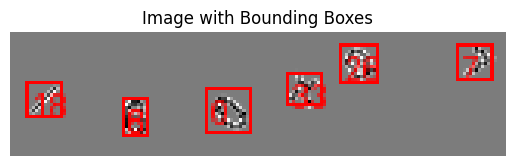

In [7]:
# Convert Labels
# category_id_labels = {
#     0: "0",
#     1: "1",
#     2: "2",
#     3: "3",
#     4: "4",
#     5: "5",
#     6: "6",
#     7: "7",
#     8: "8",
#     9: "9",
#     10: "A",
#     11: "B",
#     12: "C",
#     13: "D",
#     14: "E",
#     15: "F",
#     16: "G",
#     17: "H",
#     18: "I",
#     19: "J",
#     20: "K",
#     21: "L",
#     22: "M",
#     23: "N",
#     24: "O",
#     25: "P",
#     26: "Q",
#     27: "R",
#     28: "S",
#     29: "T",
#     30: "U",
#     31: "V",
#     32: "W",
#     33: "X",
#     34: "Y",
#     35: "Z"
# }

#labels = [category_id_labels[label.item()] for label in labels[0]]

def plot_image_with_bboxes(image, bboxes, labels, title="Image with Bounding Boxes"):
    img_height, img_width = image.shape[1], image.shape[2] 
    
    # Scale normalized bboxes to absolute pixel values for visualization
    bboxes[:, [0, 2]] *= img_width
    bboxes[:, [1, 3]] *= img_height

    # Convert to integer values for plotting
    bboxes_abs = bboxes.to(torch.int)

    # Ensure labels are strings
    if isinstance(labels, torch.Tensor):
        labels = labels.tolist()
    labels = [str(l) for l in labels]

    # Draw bounding boxes
    image_with_boxes = draw_bounding_boxes(image, bboxes_abs, labels=labels, colors="red", width=1)

    # Image tensor to NumPy for visualization
    img = image_with_boxes.permute(1, 2, 0).numpy()

    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()


plot_image_with_bboxes(image.squeeze(0), boxes[0], labels[0])